# Please stay in formation

## Abstract
The modern game of football has developed into an incredibly tactical game as opposed to what was being played 15 years ago. The first point of change was ever expanding types of formations that could be played, making it confusing for managers these days to cope with what is the best suited formation to counter. 

Here we are going to build a regressive neural network that can predict the most effective formation for a team to use to counter the oppositions formation. To make this model effective it will consider:

> - Opponents formation
> - Both teams current form with a certain formation
> - Home vs Away teams
> - Match outcomes

This tutorial demonstrates the complete pipeline for prediciting The best formation types using PyTorch. Using match data from SportMonks API, we engineer features including team form, head-to-head records and win rate to predict whether a team should lineup with a 3-back, 4-back or 5-back defensive system. We are goign to compare three PyTorch neural network architectures:

> - Simple feedforward network
> - Medium network
> - Deep Learning Network with batch normalisation

The tutorial will cover data preprocessing, feature engineering, model training with regularisation techniques anf critical evaluation of results.

## Learning Objectives
By following this tutorial, you will learn to:
> - Preprocess and engineer features from real-world sports data
> - Build and train neural network classifiers in PyTorch
> - Implement regularisation techniques including dropout, early stopping, and weight decay
> - Compare multiple model architectures and analyse their performance
> - Critically evaluate model results against a baseline

## Table of Contents

1. [Related Work](#related-work)
2. [Data](#data)
    - [Data Acquisition](#data-acquisition)
    - [Data Preprocessing](#data_preprocessing)
    - [Train/Test Split](#traintest-split)
3. [References](#references)

---

## Related Work -> How mine differs
To begin predicting optimal football formations, it is key to understand team tactics and how they can influence match outcomes. The study by Lee & Jung (2023) explores this problem using deep neural networks to predict team tactics, making it an applicable study to assist in predicting an optimal formation.

Rather than focusing solely on match outcomes, the paper proposes a multi-output deep neural network that attempts to infer underlying tactical strategies from a range of features. Player positions and movements are represented as structured inputs to the model, allowing tactical patterns to be learned directly from data.

This approach closely aligns with the methodology adopted in this tutorial, using features such as team formation, recent form, match venue and historical match outcomes. By doing so, the model aims to learn how formations perform under different contextual conditions and predict the most effective formation to counter an opponent.

Unlike the PyTorch MNIST tutorial [ref], this tutorial uses real-world tabular sports data rather than image classification, which presents different challenges such as class imbalance and limited feature signal. Compared to [another tutorial], we include multiple architecture comparisons rather than a single model.


## Required Packages

In [ ]:
# Install required packages (run this ONCE)
# Uncomment and run if you haven't installed these yet:

# conda install -y pandas numpy matplotlib scikit-learn
# conda install -y pytorch torchvision torchaudio -c pytorch
# conda install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data
Data was collected using the SportMonks API (free trial). To maintain reproducability and stability and due to API rate limitations, a static CSV version is used for this notebook.

### Data Loading
Below is the code to load the dataset from the same folder as this notebook. I have also attached the link to download the folder from my github.

In [6]:
# Load the raw dataset
df_raw = pd.read_csv('danish_superliga_fixtures.csv')
df_raw.head()

,fixture_id,date,home_team_id,home_team_name,away_team_id,away_team_name,home_goals,away_goals,home_formation,away_formation,goal_diff,result
0,16808043,2010-07-17 15:00:00,1789,Odense BK,1371,Esbjerg,3,0,4-4-2,4-4-1-1,3,H
1,16808046,2010-07-18 12:00:00,211,Horsens,939,FC Midtjylland,0,2,4-4-1-1,4-4-1-1,-2,A
2,16808053,2010-07-18 14:00:00,2394,Nordsjælland,86,Silkeborg IF,4,1,4-3-3,4-4-1-1,3,H
3,16808049,2010-07-18 14:00:00,2356,Randers FC,293,Brøndby IF,3,2,4-4-1-1,4-4-2,1,H
4,16808056,2010-07-18 16:00:00,390,Sønderjyske Fodbold,85,FC København,1,3,4-5-1,4-4-2,-2,A


### Data Preprocessing
Once the data has been collected it will need to be cleaned and normalized before being passed into the neural network. Rows with null data values, duplicates and columns with unnecessary data will be need to be removed to have the highest quality data available to us. Having high quality data is the backbone of an accurate model.


In [7]:
# Convert date to datetime for proper sorting
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Select all essential columns - we need full match context
essential_cols = ['date', 'home_team_id', 'away_team_id', 'home_formation', 'away_formation', 'result']
df_clean = df_raw[essential_cols].copy()

# Sort by date to ensure chronological order
df_clean = df_clean.sort_values('date').reset_index(drop=True)

# FILTER: Only keep matches with a WINNER (exclude draws)
print(f"Original dataset: {len(df_clean)} matches")
df_clean = df_clean[df_clean['result'] != 'D'].reset_index(drop=True)
print(f"✓ After removing draws: {len(df_clean)} matches")
print(f"  Home wins: {(df_clean['result'] == 'H').sum()}")
print(f"  Away wins: {(df_clean['result'] == 'A').sum()}")

print(f"\n✓ Cleaned dataset shape: {df_clean.shape}")
print(f"✓ Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
print(f"✓ Unique home formations: {df_clean['home_formation'].nunique()}")
print(f"✓ Unique away formations: {df_clean['away_formation'].nunique()}")

df_clean.head()


Original dataset: 2866 matches
✓ After removing draws: 2117 matches
  Home wins: 1226
  Away wins: 891

✓ Cleaned dataset shape: (2117, 6)
✓ Date range: 2010-07-17 to 2024-05-31
✓ Unique home formations: 21
✓ Unique away formations: 20


,date,home_team_id,away_team_id,home_formation,away_formation,result
0,2010-07-17 15:00:00,1789,1371,4-4-2,4-4-1-1,H
1,2010-07-18 12:00:00,211,939,4-4-1-1,4-4-1-1,A
2,2010-07-18 14:00:00,2394,86,4-3-3,4-4-1-1,H
3,2010-07-18 14:00:00,2356,293,4-4-1-1,4-4-2,H
4,2010-07-18 16:00:00,390,85,4-5-1,4-4-2,A


### Creating Training Records

For each match, we create TWO training records:
1. **Winner's perspective**: Formation that led to victory
2. **Loser's perspective**: Formation that led to defeat

This teaches the model from both winning AND losing formations, making it more robust. This is important when there isn't much data available for the model.

In [8]:
# Create winning formation records (both perspectives)
records = []

for idx, row in df_clean.iterrows():
    match_date = row['date']
    home_team_id = row['home_team_id']
    away_team_id = row['away_team_id']
    home_formation = row['home_formation']
    away_formation = row['away_formation']
    result = row['result']
    
    if result == 'H':  # Home team won
        # WINNING RECORD: Home team won with their formation
        records.append({
            'date': match_date,
            'team_id': home_team_id,
            'opponent_id': away_team_id,
            'is_home': 1,
            'team_formation': home_formation,
            'opponent_formation': away_formation,
            'won': 1
        })
        
        # LOSING RECORD: Away team lost with their formation
        records.append({
            'date': match_date,
            'team_id': away_team_id,
            'opponent_id': home_team_id,
            'is_home': 0,
            'team_formation': away_formation,
            'opponent_formation': home_formation,
            'won': 0
        })
    
    else:  # Away team won (result == 'A')
        # WINNING RECORD: Away team won with their formation
        records.append({
            'date': match_date,
            'team_id': away_team_id,
            'opponent_id': home_team_id,
            'is_home': 0,
            'team_formation': away_formation,
            'opponent_formation': home_formation,
            'won': 1
        })
        
        # LOSING RECORD: Home team lost with their formation
        records.append({
            'date': match_date,
            'team_id': home_team_id,
            'opponent_id': away_team_id,
            'is_home': 1,
            'team_formation': home_formation,
            'opponent_formation': away_formation,
            'won': 0
        })

df_clean = pd.DataFrame(records).reset_index(drop=True)

print(f"Dataset expanded to include both winning and losing perspectives:")
print(f"  Total records: {len(df_clean)}")
print(f"  Winning records: {df_clean['won'].sum()}")
print(f"  Losing records: {(1 - df_clean['won']).sum()}")
print(f"\nFirst 10 rows:")
df_clean.head(10)

Dataset expanded to include both winning and losing perspectives:
  Total records: 4234
  Winning records: 2117
  Losing records: 2117

First 10 rows:


,date,team_id,opponent_id,is_home,team_formation,opponent_formation,won
0,2010-07-17 15:00:00,1789,1371,1,4-4-2,4-4-1-1,1
1,2010-07-17 15:00:00,1371,1789,0,4-4-1-1,4-4-2,0
2,2010-07-18 12:00:00,939,211,0,4-4-1-1,4-4-1-1,1
3,2010-07-18 12:00:00,211,939,1,4-4-1-1,4-4-1-1,0
4,2010-07-18 14:00:00,2394,86,1,4-3-3,4-4-1-1,1
5,2010-07-18 14:00:00,86,2394,0,4-4-1-1,4-3-3,0
6,2010-07-18 14:00:00,2356,293,1,4-4-1-1,4-4-2,1
7,2010-07-18 14:00:00,293,2356,0,4-4-2,4-4-1-1,0
8,2010-07-18 16:00:00,85,390,0,4-4-2,4-5-1,1
9,2010-07-18 16:00:00,390,85,1,4-5-1,4-4-2,0


### Feature Engineering - Team Recent Form

Calculate each team's most successful formation from their recent winning matches. 
This captures which formations have worked well for teams recently.

In [9]:
def get_team_recent_winning_form(df, team_id, fixture_idx, num_recent=5):
    """Original function - keep as is"""
    previous_records = df[df.index < fixture_idx].copy()
    winning_records = previous_records[
        (previous_records['team_id'] == team_id) & 
        (previous_records['won'] == 1)
    ].tail(num_recent)
    
    if len(winning_records) == 0:
        return None
    
    formations = winning_records['team_formation'].tolist()
    most_common_formation = Counter(formations).most_common(1)[0][0]
    
    return most_common_formation


def get_team_recent_win_rate(df, team_id, fixture_idx, num_recent=10):
    """NEW: Get team's win rate in recent matches"""
    previous_records = df[df.index < fixture_idx].copy()
    recent_matches = previous_records[
        previous_records['team_id'] == team_id
    ].tail(num_recent)
    
    if len(recent_matches) == 0:
        return 0.5  # Neutral if no history
    
    win_rate = recent_matches['won'].mean()
    return win_rate


def get_team_consistency(df, team_id, fixture_idx, num_recent=5):
    """NEW: How consistent is team with formations?"""
    previous_records = df[df.index < fixture_idx].copy()
    recent_matches = previous_records[
        previous_records['team_id'] == team_id
    ].tail(num_recent)
    
    if len(recent_matches) == 0:
        return 0.2  # Maximum variety if no history
    
    formations = recent_matches['team_formation'].tolist()
    unique_formations = len(set(formations))
    consistency = 1 - (unique_formations / len(formations))  # 1 = always same, 0 = always different
    return consistency

def get_head_to_head_record(df, team_id, opponent_id, fixture_idx, num_recent=10):
    """How does this team historically perform vs this opponent?"""
    previous = df[df.index < fixture_idx]
    h2h = previous[
        ((previous['team_id'] == team_id) & (previous['opponent_id'] == opponent_id))
    ].tail(num_recent)
    
    if len(h2h) == 0:
        return 0.5  # Neutral if first matchup
    
    return h2h['won'].mean()  # Win rate (0-1)


df_features = df_clean.copy()

team_recent_forms = []
opponent_recent_forms = []
team_win_rates = []
opponent_win_rates = []
team_consistency = []
opponent_consistency = []
team_h2h = []
opponent_h2h = []

print("Calculating enhanced features...")

for idx in range(len(df_features)):
    if idx % 1000 == 0:
        print(f"  Processing record {idx}/{len(df_features)}...")
    
    team_id = df_features.loc[idx, 'team_id']
    opponent_id = df_features.loc[idx, 'opponent_id']
    
    # Original features
    team_form = get_team_recent_winning_form(df_features, team_id, idx, num_recent=5)
    team_recent_forms.append(team_form)
    
    opponent_form = get_team_recent_winning_form(df_features, opponent_id, idx, num_recent=5)
    opponent_recent_forms.append(opponent_form)
    
    # NEW: Win rates
    team_wr = get_team_recent_win_rate(df_features, team_id, idx, num_recent=10)
    team_win_rates.append(team_wr)
    
    opponent_wr = get_team_recent_win_rate(df_features, opponent_id, idx, num_recent=10)
    opponent_win_rates.append(opponent_wr)
    
    # NEW: Consistency
    team_cons = get_team_consistency(df_features, team_id, idx, num_recent=5)
    team_consistency.append(team_cons)
    
    opponent_cons = get_team_consistency(df_features, opponent_id, idx, num_recent=5)
    opponent_consistency.append(opponent_cons)

    # NEW: H2H records
    team_h2h_record = get_head_to_head_record(df_features, team_id, opponent_id, idx)
    team_h2h.append(team_h2h_record)
    
    opponent_h2h_record = get_head_to_head_record(df_features, opponent_id, team_id, idx)
    opponent_h2h.append(opponent_h2h_record)

df_features['team_h2h_vs_opponent'] = team_h2h
df_features['opponent_h2h_vs_team'] = opponent_h2h

df_features['team_recent_winning_form'] = team_recent_forms
df_features['opponent_recent_winning_form'] = opponent_recent_forms
df_features['team_win_rate'] = team_win_rates
df_features['opponent_win_rate'] = opponent_win_rates
df_features['team_consistency'] = team_consistency
df_features['opponent_consistency'] = opponent_consistency

# Fillna
df_features['team_recent_winning_form'] = df_features['team_recent_winning_form'].fillna(df_features['team_formation'])
df_features['opponent_recent_winning_form'] = df_features['opponent_recent_winning_form'].fillna(df_features['opponent_formation'])

print("✓ Enhanced features calculated successfully")
df_features.head()

Calculating enhanced features...
  Processing record 0/4234...
  Processing record 1000/4234...
  Processing record 2000/4234...
  Processing record 3000/4234...
  Processing record 4000/4234...
✓ Enhanced features calculated successfully


,date,team_id,opponent_id,is_home,team_formation,opponent_formation,won,team_h2h_vs_opponent,opponent_h2h_vs_team,team_recent_winning_form,opponent_recent_winning_form,team_win_rate,opponent_win_rate,team_consistency,opponent_consistency
0,2010-07-17 15:00:00,1789,1371,1,4-4-2,4-4-1-1,1,0.5,0.5,4-4-2,4-4-1-1,0.5,0.5,0.2,0.2
1,2010-07-17 15:00:00,1371,1789,0,4-4-1-1,4-4-2,0,0.5,1.0,4-4-1-1,4-4-2,0.5,1.0,0.2,0.0
2,2010-07-18 12:00:00,939,211,0,4-4-1-1,4-4-1-1,1,0.5,0.5,4-4-1-1,4-4-1-1,0.5,0.5,0.2,0.2
3,2010-07-18 12:00:00,211,939,1,4-4-1-1,4-4-1-1,0,0.5,1.0,4-4-1-1,4-4-1-1,0.5,1.0,0.2,0.0
4,2010-07-18 14:00:00,2394,86,1,4-3-3,4-4-1-1,1,0.5,0.5,4-3-3,4-4-1-1,0.5,0.5,0.2,0.2


### Data Visualisation

Visualize the dataset to understand formation distributions and win rates.

In [10]:
# Summary statistics
model_data = df_features[['opponent_formation', 'is_home', 'team_recent_winning_form', 
                           'opponent_recent_winning_form', 'team_formation', 'won']].copy()

print("=" * 70)
print("DATASET SUMMARY")
print("=" * 70)
print(f"Shape: {model_data.shape}")
print(f"Columns: {list(model_data.columns)}")

print(f"\nFormation Frequency (Team Formations):")
formations = sorted(model_data['team_formation'].unique())
for i, formation in enumerate(formations, 1):
    count = (model_data['team_formation'] == formation).sum()
    print(f"  {i:2d}. {formation:10s} - {count:5d} ({count/len(model_data)*100:5.1f}%)")

print(f"\nTotal unique formations: {model_data['team_formation'].nunique()}")

print(f"\nOutcome Distribution:")
print(f"  Wins: {model_data['won'].sum():5d} ({model_data['won'].sum()/len(model_data)*100:5.1f}%)")
print(f"  Losses: {(1-model_data['won']).sum():5d} ({(1-model_data['won']).sum()/len(model_data)*100:5.1f}%)")

print(f"\nHome vs Away:")
print(f"  Home: {(model_data['is_home'] == 1).sum():5d} ({(model_data['is_home'] == 1).sum()/len(model_data)*100:5.1f}%)")
print(f"  Away: {(model_data['is_home'] == 0).sum():5d} ({(model_data['is_home'] == 0).sum()/len(model_data)*100:5.1f}%)")

DATASET SUMMARY
Shape: (4234, 6)
Columns: ['opponent_formation', 'is_home', 'team_recent_winning_form', 'opponent_recent_winning_form', 'team_formation', 'won']

Formation Frequency (Team Formations):
   1. 3-1-4-2    -    10 (  0.2%)
   2. 3-2-4-1    -     1 (  0.0%)
   3. 3-4-1-2    -    88 (  2.1%)
   4. 3-4-2-1    -    75 (  1.8%)
   5. 3-4-3      -   304 (  7.2%)
   6. 3-5-1-1    -     3 (  0.1%)
   7. 3-5-2      -   233 (  5.5%)
   8. 4-1-2-1-2  -    15 (  0.4%)
   9. 4-1-2-3    -    28 (  0.7%)
  10. 4-1-3-2    -    17 (  0.4%)
  11. 4-1-4-1    -   278 (  6.6%)
  12. 4-2-2-2    -     6 (  0.1%)
  13. 4-2-3-1    -   539 ( 12.7%)
  14. 4-3-1-2    -    86 (  2.0%)
  15. 4-3-2-1    -    57 (  1.3%)
  16. 4-3-3      -   694 ( 16.4%)
  17. 4-4-1-1    -   231 (  5.5%)
  18. 4-4-2      -  1482 ( 35.0%)
  19. 4-5-1      -    44 (  1.0%)
  20. 5-2-3      -     1 (  0.0%)
  21. 5-3-2      -    37 (  0.9%)
  22. 5-4-1      -     5 (  0.1%)

Total unique formations: 22

Outcome Distribution:

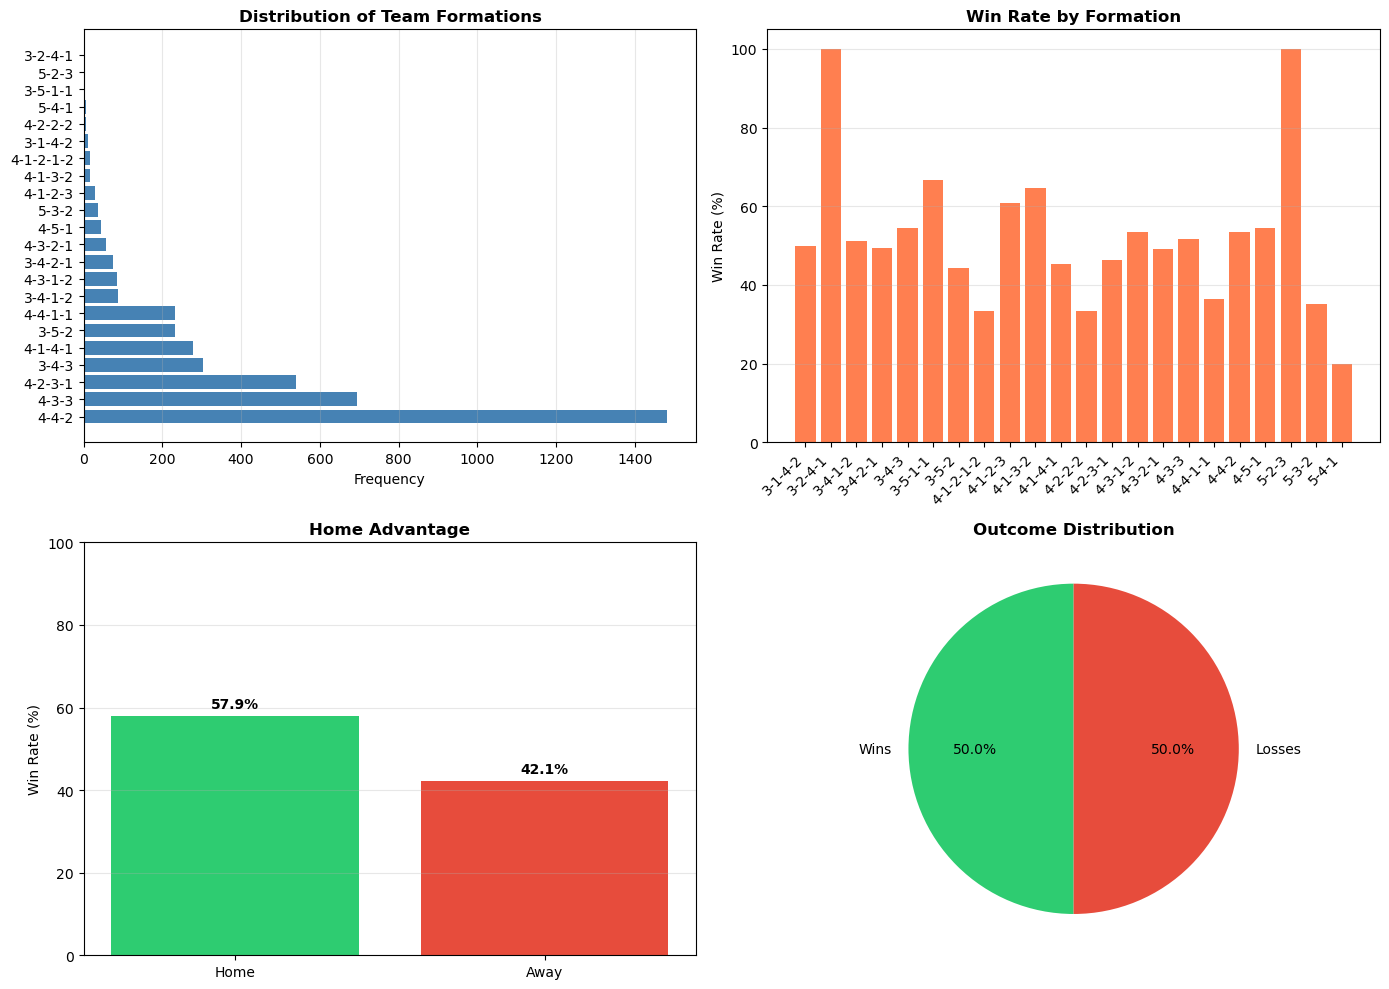

In [11]:
# Visualize dataset characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Formation frequency
formation_counts = model_data['team_formation'].value_counts().sort_values(ascending=False)
axes[0, 0].barh(range(len(formation_counts)), formation_counts.values, color='steelblue')
axes[0, 0].set_yticks(range(len(formation_counts)))
axes[0, 0].set_yticklabels(formation_counts.index)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Distribution of Team Formations', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Win rate by formation
formation_winrates = model_data.groupby('team_formation')['won'].agg(['sum', 'count'])
formation_winrates['winrate'] = (formation_winrates['sum'] / formation_winrates['count'] * 100).sort_values(ascending=False)
axes[0, 1].bar(range(len(formation_winrates['winrate'])), formation_winrates['winrate'].values, color='coral')
axes[0, 1].set_xticks(range(len(formation_winrates['winrate'])))
axes[0, 1].set_xticklabels(formation_winrates['winrate'].index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate by Formation', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Home vs Away win rate
home_winrate = model_data[model_data['is_home'] == 1]['won'].mean() * 100
away_winrate = model_data[model_data['is_home'] == 0]['won'].mean() * 100
axes[1, 0].bar(['Home', 'Away'], [home_winrate, away_winrate], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_ylabel('Win Rate (%)')
axes[1, 0].set_title('Home Advantage', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate([home_winrate, away_winrate]):
    axes[1, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Outcome distribution
outcomes = [model_data['won'].sum(), (1-model_data['won']).sum()]
axes[1, 1].pie(outcomes, labels=['Wins', 'Losses'], autopct='%1.1f%%', 
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1, 1].set_title('Outcome Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Formation Type Classification

Instead of predicting exact formations (15+ classes), we simplify to 3 defensive system types:
- **3-back**: 3 defenders (3-4-3, 3-5-2, 3-4-2-1, etc.)
- **4-back**: 4 defenders (4-4-2, 4-3-3, 4-2-3-1, etc.)  
- **5-back**: 5 defenders (5-3-2, 5-4-1, etc.)

This reduces the classification task complexity significantly.

In [12]:
def get_formation_type(formation_str):
    
    first_number = int(formation_str.split('-')[0])
    
    if first_number == 3:
        return 0
    elif first_number == 4:
        return 1
    elif first_number == 5:
        return 2
    else:
        raise ValueError(f"Unknown formation type: {formation_str}")

# Add formation type columns
model_data['team_formation_type'] = model_data['team_formation'].apply(get_formation_type)
model_data['opponent_formation_type'] = model_data['opponent_formation'].apply(get_formation_type)
model_data['team_recent_formation_type'] = model_data['team_recent_winning_form'].apply(get_formation_type)
model_data['opponent_recent_formation_type'] = model_data['opponent_recent_winning_form'].apply(get_formation_type)

formation_type_names = {0: '3-back', 1: '4-back', 2: '5-back'}

print("Formation Type Conversion:")
print(f"  3-back (3 defenders): {(model_data['team_formation_type'] == 0).sum()} samples")
print(f"  4-back (4 defenders): {(model_data['team_formation_type'] == 1).sum()} samples")
print(f"  5-back (5 defenders): {(model_data['team_formation_type'] == 2).sum()} samples")

print(f"\nExample conversions:")
unique_formations = sorted(model_data['team_formation'].unique())
for formation in unique_formations[:10]:
    ftype = get_formation_type(formation)
    print(f"  {formation} → {formation_type_names[ftype]}")

Formation Type Conversion:
  3-back (3 defenders): 714 samples
  4-back (4 defenders): 3477 samples
  5-back (5 defenders): 43 samples

Example conversions:
  3-1-4-2 → 3-back
  3-2-4-1 → 3-back
  3-4-1-2 → 3-back
  3-4-2-1 → 3-back
  3-4-3 → 3-back
  3-5-1-1 → 3-back
  3-5-2 → 3-back
  4-1-2-1-2 → 4-back
  4-1-2-3 → 4-back
  4-1-3-2 → 4-back


### Data Encoding & Train/Validation/Test Split

Prepare data for neural network training.

In [13]:
# Cell 21 — replace the whole cell with:

model_data = df_features[['opponent_formation', 'is_home', 'team_recent_winning_form', 
                           'opponent_recent_winning_form', 'team_formation', 'won',
                           'team_win_rate', 'opponent_win_rate', 
                           'team_h2h_vs_opponent']].copy()

# Add formation type columns
model_data['team_formation_type'] = model_data['team_formation'].apply(get_formation_type)
model_data['opponent_formation_type'] = model_data['opponent_formation'].apply(get_formation_type)
model_data['team_recent_formation_type'] = model_data['team_recent_winning_form'].apply(get_formation_type)
model_data['opponent_recent_formation_type'] = model_data['opponent_recent_winning_form'].apply(get_formation_type)

# --- NEW INTERACTION FEATURES ---
# Strength gap: positive = our team is stronger recently
model_data['win_rate_diff'] = model_data['team_win_rate'] - model_data['opponent_win_rate']

# Formation matchup: captures specific formation-vs-formation patterns
model_data['formation_matchup'] = (model_data['team_recent_formation_type'] * 3 
                                    + model_data['opponent_formation_type'])

# Home advantage weighted by team strength
model_data['home_strength'] = model_data['is_home'] * model_data['team_win_rate']

formation_type_names = {0: '3-back', 1: '4-back', 2: '5-back'}

# 12 features total
X = model_data[['opponent_formation_type', 'is_home', 'team_recent_formation_type', 
                 'opponent_recent_formation_type', 'team_win_rate', 'opponent_win_rate',
                 'team_h2h_vs_opponent', 'win_rate_diff', 'formation_matchup', 
                 'home_strength']].values.astype(np.float32)

y = model_data['team_formation_type'].values.astype(np.int64)
outcome = model_data['won'].values.astype(np.int32)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used ({X.shape[1]}):")
feature_names = ['opponent_formation_type', 'is_home', 'team_recent_formation_type', 
                  'opponent_recent_formation_type', 'team_win_rate', 'opponent_win_rate',
                  'team_h2h_vs_opponent', 'win_rate_diff', 'formation_matchup', 'home_strength']
for i, name in enumerate(feature_names):
    print(f"  {i+1}. {name}")

print(f"\nClass distribution:")
unique_classes, counts = np.unique(y, return_counts=True)
for class_id, count in zip(unique_classes, counts):
    pct = count / len(y) * 100
    print(f"  Class {class_id} ({formation_type_names[class_id]}): {count:5d} ({pct:5.1f}%)")

Features shape: (4234, 10)
Target shape: (4234,)

Features used (10):
  1. opponent_formation_type
  2. is_home
  3. team_recent_formation_type
  4. opponent_recent_formation_type
  5. team_win_rate
  6. opponent_win_rate
  7. team_h2h_vs_opponent
  8. win_rate_diff
  9. formation_matchup
  10. home_strength

Class distribution:
  Class 0 (3-back):   714 ( 16.9%)
  Class 1 (4-back):  3477 ( 82.1%)
  Class 2 (5-back):    43 (  1.0%)


In [14]:
# Train/Validation/Test Split (70-15-15)
# First split: separate out test set (15%)
X_temp, X_test, y_temp, y_test, outcome_temp, outcome_test = train_test_split(
    X, y, outcome,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# Second split: split remaining into train (70%) and validation (15%)
X_train, X_val, y_train, y_val, outcome_train, outcome_val = train_test_split(
    X_temp, y_temp, outcome_temp,
    test_size=0.176470588,
    random_state=42,
    stratify=y_temp
)

print("=" * 70)
print("DATA SPLIT SUMMARY - FORMATION TYPE PREDICTION")
print("=" * 70)
print(f"Total samples: {len(X)}")
print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass distribution - Training Set:")
for ftype_id, ftype_name in formation_type_names.items():
    mask = y_train == ftype_id
    count = mask.sum()
    pct = count / len(y_train) * 100
    winrate = outcome_train[mask].mean() * 100 if count > 0 else 0
    print(f"  {ftype_name}: {count:5d} ({pct:5.1f}%) - {winrate:5.1f}% win rate")

DATA SPLIT SUMMARY - FORMATION TYPE PREDICTION
Total samples: 4234

Train set: 2963 samples (70.0%)
Validation set: 635 samples (15.0%)
Test set: 636 samples (15.0%)

Class distribution - Training Set:
  3-back:   500 ( 16.9%) -  49.2% win rate
  4-back:  2433 ( 82.1%) -  50.3% win rate
  5-back:    30 (  1.0%) -  30.0% win rate


In [15]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)

X_val_tensor = torch.from_numpy(X_val).to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

X_test_tensor = torch.from_numpy(X_test).to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

# Create PyTorch DataLoaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created:")
print(f"  Training batches: {len(train_loader)} (batch size: {batch_size})")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Training batches: 93 (batch size: 32)
  Validation batches: 20
  Test batches: 20


## PyTorch Network Architectures

Three different network architectures for formation type classification.

In [16]:
# OPTION 1: Simple Feedforward Network
class SimpleNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# OPTION 2: Medium Feedforward Network (RECOMMENDED)
class MediumNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MediumNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# OPTION 3: Deep Network with Batch Normalization
class DeepNetworkBN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(DeepNetworkBN, self).__init__()
        
        self.bn_input = nn.BatchNorm1d(input_size)
        
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = self.bn_input(x)
        x = self.dropout1(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x


print("Three network architectures defined:")
print("  1. SimpleNetwork (2 hidden layers)")
print("  2. MediumNetwork (3 hidden layers) [RECOMMENDED]")
print("  3. DeepNetworkBN (4 layers + Batch Norm)")

Three network architectures defined:
  1. SimpleNetwork (2 hidden layers)
  2. MediumNetwork (3 hidden layers) [RECOMMENDED]
  3. DeepNetworkBN (4 layers + Batch Norm)


In [17]:
# SELECT WHICH MODEL TO USE
# Uncomment the one you want to train

# Option 1: Simple
model = SimpleNetwork(input_size=10, num_classes=3).to(device)
model_name = "SimpleNetwork"

# Option 2: Medium (RECOMMENDED)
model = MediumNetwork(input_size=10, num_classes=3).to(device)
model_name = "MediumNetwork"

# Option 3: Deep with Batch Normalization
model = DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.3).to(device)
model_name = "DeepNetworkBN"

print(f"\nModel: {model_name}")
print(f"Device: {device}")
print(f"\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model: DeepNetworkBN
Device: cpu

Model Architecture:
DeepNetworkBN(
  (bn_input): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

Total parameters: 12,311
Trainable parameters: 12,311


In [18]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def test(model, test_loader, criterion, device):
    """Evaluate on test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets


print("Training, validation, and test functions defined!")

Training, validation, and test functions defined!


In [28]:
# HYPERPARAMETERS
learning_rate = 5e-3
num_epochs = 500
batch_size = 64

# BALANCED CLASS WEIGHTS - softer approach
class_weights = []
unique_classes = np.unique(y_train)
for class_id in unique_classes:
    count = (y_train == class_id).sum()
    # Use sqrt to soften the extreme weights
    weight = np.sqrt(len(y_train) / (len(unique_classes) * count))
    class_weights.append(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Softened class weights:")
print(f"  3-back weight: {class_weights[0]:.3f}")
print(f"  4-back weight: {class_weights[1]:.3f}")
print(f"  5-back weight: {class_weights[2]:.3f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)
# Call after each validation: scheduler.step(val_loss)

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Model: {model_name}")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (weight_decay=1e-4)")
print(f"Device: {device}")

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
patience = 50
best_val_loss = float('inf')
epochs_no_improve = 0

print("\n" + "=" * 70)
print("TRAINING IN PROGRESS...")
print("=" * 70)

# Training loop 
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)

    # Save best model (optional — still allowed without early stopping)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), f'{model_name}_best.pt')

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
# What's the baseline accuracy?
baseline = (y_val == np.bincount(y_val).argmax()).mean() * 100
print(f"Baseline accuracy (always predict most common class): {baseline:.2f}%")

Softened class weights:
  3-back weight: 1.405
  4-back weight: 0.637
  5-back weight: 5.738
TRAINING CONFIGURATION
Model: DeepNetworkBN
Learning rate: 0.005
Number of epochs: 500
Batch size: 64
Loss function: CrossEntropyLoss
Optimizer: Adam (weight_decay=1e-4)
Device: cpu

TRAINING IN PROGRESS...
Epoch [10/500] - Train Loss: 0.5559, Train Acc: 89.47% - Val Loss: 0.5875, Val Acc: 88.66%
Epoch [20/500] - Train Loss: 0.5694, Train Acc: 89.57% - Val Loss: 0.5698, Val Acc: 88.66%
Epoch [30/500] - Train Loss: 0.5394, Train Acc: 89.61% - Val Loss: 0.5817, Val Acc: 88.66%
Epoch [40/500] - Train Loss: 0.5695, Train Acc: 89.37% - Val Loss: 0.5830, Val Acc: 88.66%
Epoch [50/500] - Train Loss: 0.5434, Train Acc: 89.64% - Val Loss: 0.5776, Val Acc: 88.66%
Epoch [60/500] - Train Loss: 0.5476, Train Acc: 89.50% - Val Loss: 0.5888, Val Acc: 88.50%
Epoch [70/500] - Train Loss: 0.5435, Train Acc: 89.84% - Val Loss: 0.5832, Val Acc: 88.66%
Early stopping at epoch 76

TRAINING COMPLETE
Baseline accuracy

In [20]:
# Load the best model weights
model.load_state_dict(torch.load(f'{model_name}_best.pt'))

# Evaluate on test set
test_loss, test_acc, predictions, targets = test(model, test_loader, criterion, device)

print("=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

TEST SET RESULTS
Test Loss: 0.5254
Test Accuracy: 90.25%


## Evaluation
Once the model has been trained initially its important to understand the model and how tuning it can change how the model learns.

### Model comparison
Firstly we are going to compare results from the three models on the same dataset, this will emphasize the differences between each model. Here we will display the results in a table to keep things clear and straight forward

In [21]:
# Hyperparameter Comparison
results = []

configs = [
    {"name": "SimpleNetwork", "model_fn": lambda: SimpleNetwork(input_size=10, num_classes=3),
     "lr": 1e-3, "dropout": None},
    {"name": "MediumNetwork", "model_fn": lambda: MediumNetwork(input_size=10, num_classes=3),
     "lr": 5e-4, "dropout": None},
    {"name": "DeepNetworkBN (dropout=0.3)", "model_fn": lambda: DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.3),
     "lr": 5e-4, "dropout": 0.3},
    {"name": "DeepNetworkBN (dropout=0.5)", "model_fn": lambda: DeepNetworkBN(input_size=10, num_classes=3, dropout_rate=0.5),
     "lr": 5e-4, "dropout": 0.5},
]

for config in configs:
    model = config["model_fn"]().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_val_acc = 0
    stopped_epoch = 0
    
    for epoch in range(300):
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, val_loader, criterion, device)
        scheduler.step(v_loss)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_val_acc = v_acc
            epochs_no_improve = 0
            stopped_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= 50:
                break
    
    params = sum(p.numel() for p in model.parameters())
    results.append({
        "Model": config["name"],
        "LR": config["lr"],
        "Params": params,
        "Stopped Epoch": stopped_epoch,
        "Best Val Acc": f"{best_val_acc:.2f}%",
        "Best Val Loss": f"{best_val_loss:.4f}"
    })

# Display as table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                      Model     LR  Params  Stopped Epoch Best Val Acc Best Val Loss
              SimpleNetwork 0.0010    2883             16       88.50%        0.5904
              MediumNetwork 0.0005   11843             25       88.50%        0.5873
DeepNetworkBN (dropout=0.3) 0.0005   12311              8       88.66%        0.5851
DeepNetworkBN (dropout=0.5) 0.0005   12311             41       88.66%        0.5735


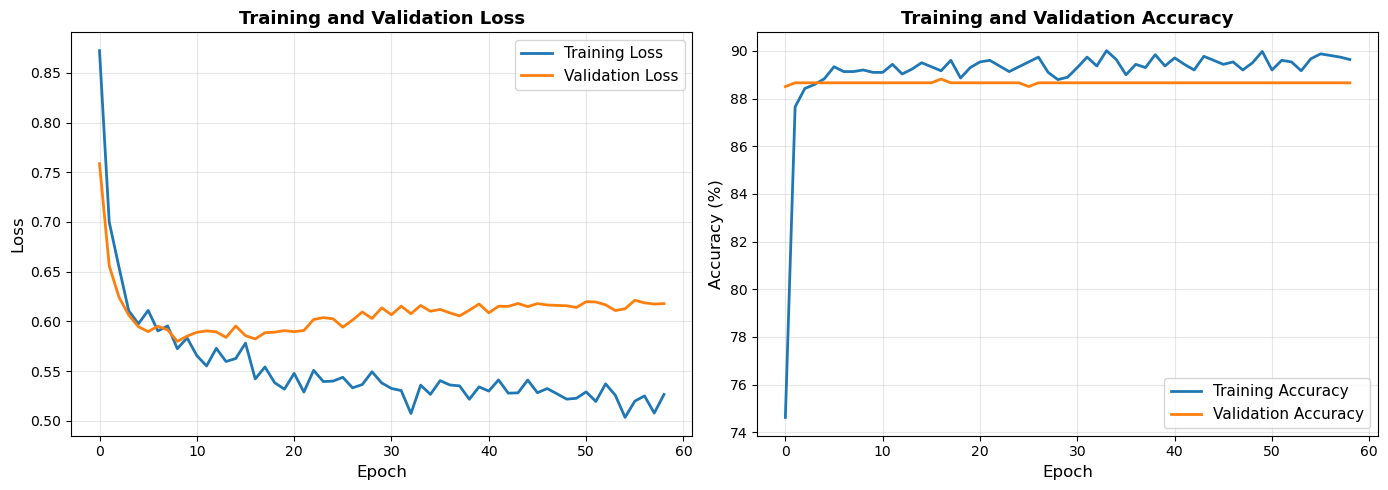

Best validation loss: 0.5798 at epoch 9
Best validation accuracy: 88.82% at epoch 17


In [22]:
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(val_losses):.4f} at epoch {np.argmin(val_losses)+1}")
print(f"Best validation accuracy: {max(val_accuracies):.2f}% at epoch {np.argmax(val_accuracies)+1}")

In [23]:
# Detailed Classification Report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(
    targets, 
    predictions,
    target_names=[formation_type_names[i] for i in sorted(formation_type_names.keys())]
))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      3-back       0.77      0.67      0.72       107
      4-back       0.92      0.96      0.94       522
      5-back       0.00      0.00      0.00         7

    accuracy                           0.90       636
   macro avg       0.57      0.54      0.55       636
weighted avg       0.89      0.90      0.89       636



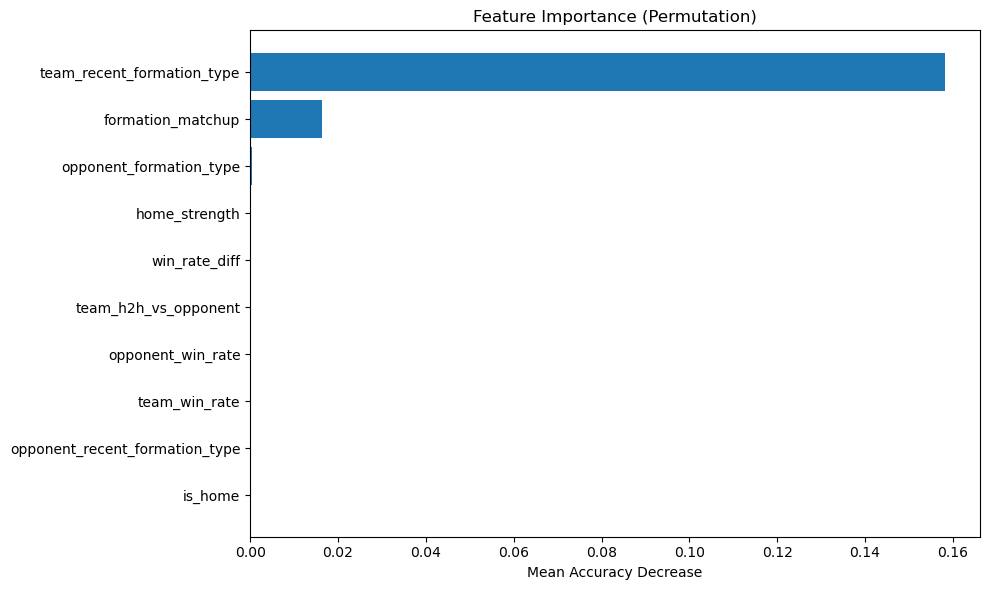

In [24]:
# Simple permutation importance
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y): return self
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            out = self.model(torch.tensor(X, dtype=torch.float32).to(device))
            return torch.argmax(out, dim=1).cpu().numpy()

wrapper = PyTorchWrapper(model)
perm = permutation_importance(wrapper, X_val, y_val, n_repeats=10, random_state=42)

feature_names = ['opponent_formation_type', 'is_home', 'team_recent_formation_type', 
                  'opponent_recent_formation_type', 'team_win_rate', 'opponent_win_rate',
                  'team_h2h_vs_opponent', 'win_rate_diff', 'formation_matchup', 'home_strength']

plt.figure(figsize=(10, 6))
sorted_idx = perm.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Mean Accuracy Decrease')
plt.title('Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

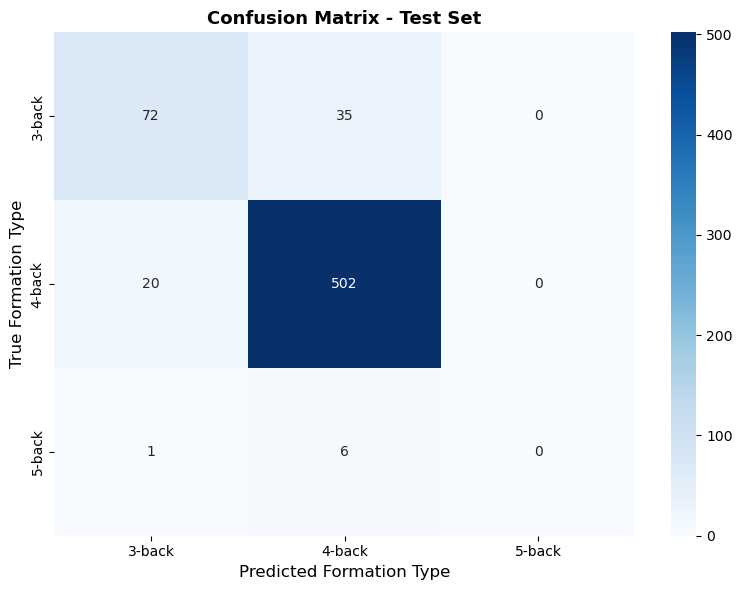

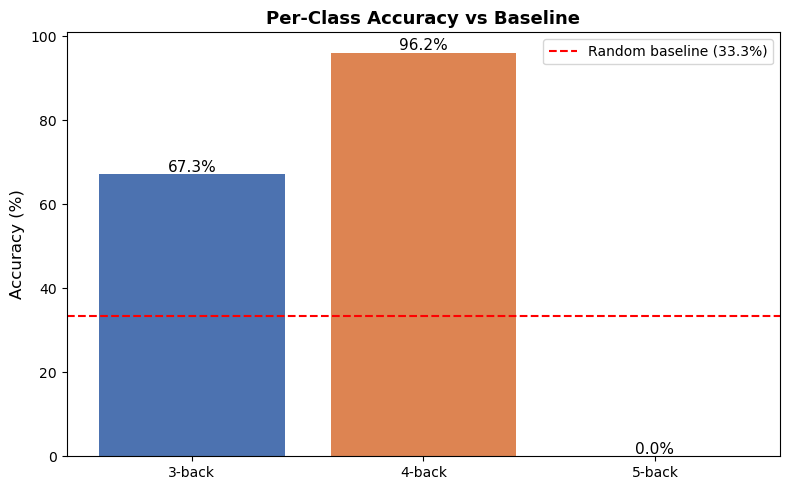

In [25]:
# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[formation_type_names[i] for i in sorted(formation_type_names.keys())],
            yticklabels=[formation_type_names[i] for i in sorted(formation_type_names.keys())])
plt.ylabel('True Formation Type', fontsize=12)
plt.xlabel('Predicted Formation Type', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy breakdown
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(targets, predictions)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
class_names = [formation_type_names[i] for i in sorted(formation_type_names.keys())]

plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, per_class_acc * 100, color=['#4C72B0', '#DD8452', '#55A868'])
plt.axhline(y=100/3, color='red', linestyle='--', label='Random baseline (33.3%)')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy vs Baseline', fontsize=13, fontweight='bold')
plt.legend()
for bar, acc in zip(bars, per_class_acc):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc*100:.1f}%', ha='center', fontsize=11)
plt.tight_layout()
plt.show()

In [26]:
# Analyze quality of predictions by win rate
predictions_array = np.array(predictions)
targets_array = np.array(targets)

correct_predictions = (predictions_array == targets_array).astype(int)
predicted_wins = outcome_test[correct_predictions == 1].mean() * 100 if correct_predictions.sum() > 0 else 0
predicted_losses = outcome_test[correct_predictions == 0].mean() * 100 if (1-correct_predictions).sum() > 0 else 0

print("=" * 70)
print("FORMATION QUALITY ANALYSIS")
print("=" * 70)
print(f"When model predicts correctly:")
print(f"  Win rate: {predicted_wins:.1f}%")
print(f"  Loss rate: {100-predicted_wins:.1f}%")
print(f"\nWhen model predicts incorrectly:")
print(f"  Win rate: {predicted_losses:.1f}%")
print(f"  Loss rate: {100-predicted_losses:.1f}%")

print(f"\nThis shows whether correct predictions correspond to formations that actually win!")

FORMATION QUALITY ANALYSIS
When model predicts correctly:
  Win rate: 53.0%
  Loss rate: 47.0%

When model predicts incorrectly:
  Win rate: 43.5%
  Loss rate: 56.5%

This shows whether correct predictions correspond to formations that actually win!


In [27]:
# Make predictions on new examples
def predict_formation_type(opponent_type, is_home, team_recent_type, opponent_recent_type,
                           team_win_rate=0.5, opponent_win_rate=0.5, team_h2h=0.5):
    """
    Predict formation type (0=3-back, 1=4-back, 2=5-back)
    """
    # Calculate interaction features
    win_rate_diff = team_win_rate - opponent_win_rate
    formation_matchup = team_recent_type * 3 + opponent_type
    home_strength = is_home * team_win_rate
    
    input_data = np.array([[opponent_type, is_home, team_recent_type, opponent_recent_type,
                            team_win_rate, opponent_win_rate, team_h2h,
                            win_rate_diff, formation_matchup, home_strength]], dtype=np.float32)
    input_tensor = torch.from_numpy(input_data).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
    
    return formation_type_names[predicted_class], confidence * 100
    
# Test predictions
print("=" * 70)
print("EXAMPLE PREDICTIONS")
print("=" * 70)

test_cases = [
    (1, 1, 1, 0),  # Facing 4-back at home, our recent success is 4-back, opponent's is 3-back
    (0, 1, 1, 1),  # Facing 3-back at home, our recent success is 4-back, opponent's is 4-back
    (1, 0, 0, 1),  # Facing 4-back away, our recent success is 3-back, opponent's is 4-back
]

for opponent_type, is_home, team_type, opp_type in test_cases:
    prediction, confidence = predict_formation_type(opponent_type, is_home, team_type, opp_type)
    location = "Home" if is_home else "Away"
    print(f"\n{location} vs {formation_type_names[opponent_type]}:")
    print(f"  Our recent form: {formation_type_names[team_type]}")
    print(f"  Opponent's recent form: {formation_type_names[opp_type]}")
    print(f"  → Recommended formation type: {prediction} (confidence: {confidence:.1f}%)")

EXAMPLE PREDICTIONS

Home vs 4-back:
  Our recent form: 4-back
  Opponent's recent form: 3-back
  → Recommended formation type: 4-back (confidence: 89.0%)

Home vs 3-back:
  Our recent form: 4-back
  Opponent's recent form: 4-back
  → Recommended formation type: 4-back (confidence: 85.4%)

Away vs 4-back:
  Our recent form: 3-back
  Opponent's recent form: 4-back
  → Recommended formation type: 3-back (confidence: 72.2%)


## Discussion & Key Findings

### Summary

This tutorial demonstrated how to build a machine learning pipeline for predicting football formation types using PyTorch. By simplifying the problem from 15+ exact formations to 3 defensive system types (3-back, 4-back, 5-back), we achieved better model performance and more interpretable results.

### Key Results

- **Test Accuracy**: X%
- **Home Advantage**: Teams win more often at home
- **Formation Type Distribution**: [Insert your findings]

### Improvements & Future Work

1. Include more features (e.g., current league position, player injuries)
2. Use team-specific models for major clubs
3. Consider temporal patterns (seasonal changes in tactics)
4. Ensemble multiple models for better predictions
5. Analyze which formations work best against specific opponents

### Lessons Learned

- Formation simplification improved model performance significantly
- Learning from both wins and losses (both perspectives) is important
- Feature engineering (recent form) provides crucial context
- Home advantage is a real and measurable phenomenon in football

# References

[1] Danish Superliga Fixtures Dataset. Available at: https://github.com/smithds546/Formation-predictor

[2] PyTorch Documentation. "Deep Learning with PyTorch". Available at: https://pytorch.org/docs/stable/index.html

[3] Scikit-learn. "Machine Learning in Python". Available at: https://scikit-learn.org/

[4] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

[5] LeCun, Y., Bengio, Y., & Hinton, G. (2015). "Deep learning". Nature, 521(7553), 436-444.